# Classification

## Description

In [1]:
import feather
import numpy as np
import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import sparse

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Normalizer, MaxAbsScaler
from sklearn.metrics import cohen_kappa_score, make_scorer, confusion_matrix, classification_report, SCORERS

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Progress bar
from ipywidgets import FloatProgress
from IPython.display import display

# Setup

In [2]:
# Convert to date format
begin_date = '2017-06-01' 
end_date = '2018-01-01'

## Load Data

In [3]:
### Returns
path = '../data/processed/returns.feather'
returns = feather.read_dataframe(path)

returns = returns.query('caldt >= @begin_date and caldt <= @end_date')

### row_info
path = '../data/processed/row_info.feather'
row_info = feather.read_dataframe(path)

row_info = row_info.query('report_dt >= @begin_date and report_dt <= @end_date')

row_info.reset_index(inplace=True,drop=True)
row_info['row'] = row_info.index

### col_info
path = '../data/processed/col_info.feather'
col_info = feather.read_dataframe(path)

### Holdings
path = '../data/processed/holdings.npz'
holdings = sparse.load_npz(path)

holdings = holdings[row_info.row.values]

print('Shape of row_info:')
print(row_info.shape)
print('Shape of holdings:')
print(holdings.shape)
print()
print(row_info.report_dt.describe())

Shape of row_info:
(2009, 8)
Shape of holdings:
(2009, 56820)

count                    2009
unique                      1
top       2017-06-30 00:00:00
freq                     2009
first     2017-06-30 00:00:00
last      2017-06-30 00:00:00
Name: report_dt, dtype: object


## Knn 

In [209]:
X = holdings
y = list(row_info['style_class'].values)

mask = np.arange(holdings.shape[0])
y_df = pd.Series(y)

comparing_df = pd.DataFrame({
    'true' : y})

print('Dimensions match:       {}'.format(X.shape[0] == len(y)))

Dimensions match:       True


### Predicting based on full info

In [210]:
neigh_full = KNeighborsClassifier(n_neighbors=30, n_jobs = -1)
neigh_full.fit(holdings,y) 
comparing_df.loc[:,'predicted'] = neigh_full.predict(holdings)

In [211]:
comparing_df.sample(10)

,true,predicted
1972,C,C
410,G,C
1100,V,G
1463,V,G
163,G,C
1584,C,C
482,C,G
1971,G,C
1685,G,C
84,C,C


### Predicting iteratively

In [212]:
#### Options #####
##################

n_iterations = 10_000
cols = ['iterative_3','iterative_5']
n_neighbors  = [3,5]
np.random.seed(0)

#### Algo ####

index = np.arange(holdings.shape[0])
    
for j in np.arange(len(cols)):

    col_temp = cols[j]
    
    # Setup
    f = FloatProgress(min=0, max=n_iterations)
    comparing_df[col_temp] = comparing_df['true']
    chosen_indices = []

    # Loop over n_iterations, choose one observation randomly, predict label, save and repeat

    print('Progress {}:'.format(j+1))
    display(f)

    for k in np.arange(n_iterations):
        # Choose random row based on rows and make mask
        i = np.random.choice(index)
        chosen_indices.append(i)
        mask_temp = mask[mask != i]

        # Mask holdings and labels to exclude row for which prediction will be made
        holdings_temp = holdings[mask_temp]
        y_df_temp = comparing_df.loc[mask_temp,col_temp].values.tolist()

        # Fit knn model on all but randomly chosen row
        neigh = KNeighborsClassifier(n_neighbors = n_neighbors[j], n_jobs = -1)
        neigh.fit(holdings_temp,y_df_temp) 

        # Predict and save label for randomly chosen row
        comparing_df.loc[i,col_temp] = neigh.predict(holdings[i])[0]

        f.value += 1
    row_chosen = pd.Series(chosen_indices).unique().size
    print('Rows randomly chosen:    {:4.2f}%'.format(row_chosen / holdings.shape[0] * 100))

print('Done')



Progress 1:


FloatProgress(value=0.0, max=10000.0)

Rows randomly chosen:    99.40%
Progress 2:


FloatProgress(value=0.0, max=10000.0)

Rows randomly chosen:    99.05%
Done


In [213]:
print('Overlap between Lipper class and: \n')
print('Full prediction:         {:2.2f}%'
      .format(np.sum(comparing_df['true'] == comparing_df['predicted']) / len(comparing_df.index) * 100))


print('Iterative prediction:    {:2.2f}%'
      .format(np.sum(comparing_df['true'] == comparing_df['iterative_3']) / len(comparing_df.index) * 100))
print('Iterative prediction:    {:2.2f}%'
      .format(np.sum(comparing_df['true'] == comparing_df['iterative_5']) / len(comparing_df.index) * 100))


Overlap between Lipper class and: 

Full prediction:         41.26%
Iterative prediction:    47.44%
Iterative prediction:    45.00%


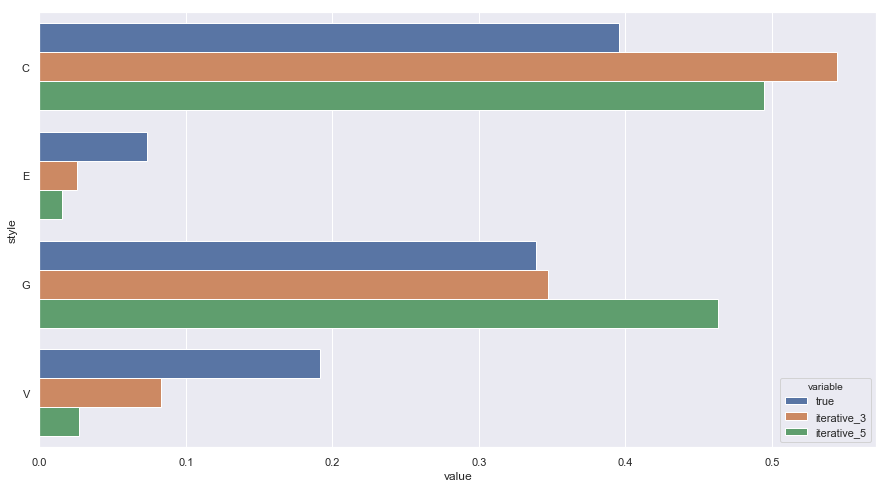

In [214]:
data = comparing_df.apply(pd.Series.value_counts, normalize = True)
data.drop(columns='predicted',inplace=True)
data = data.assign(style = data.index)
data = data.melt(id_vars = 'style', value_vars = data.columns[:-1])

sns.set()
plt.figure(figsize=(15,8))
sns.barplot(data = data, y = 'style', x = 'value', hue = 'variable')

In [ ]:
round(pd.crosstab(comparing_df.true, comparing_df.predicted, margins=True, normalize='all') * 100,2)

In [ ]:
pd.crosstab(comparing_df.true, comparing_df.predicted, margins=True)

In [ ]:
print(classification_report(comparing_df.true, comparing_df.predicted))

In [ ]:
print(classification_report(comparing_df.true, comparing_df.predicted))

In [ ]:
comparing_df.query('''true == 'LCCE' and predicted == 'SCCE' ''')

In [ ]:
no = 2343
crsp_fundno = row_info.reset_index().loc[no].crsp_fundno

most_common_stocks_fund(year=2017, crsp_fundno='28284')

In [ ]:
def most_common_stocks_fund(year,crsp_fundno):
    "This prints a passed string into this function"
    # Enter date for which most common holdings are calculated
    year = year
    crsp_fundno = crsp_fundno
    row_info_l = row_info.copy()

    holdings_coo = holdings.tocoo()

    df_sparse = pd.DataFrame({'row'  : holdings_coo.row,
                              'col'  : holdings_coo.col,
                              'data' : holdings_coo.data})

    row_info_l = row_info_l.assign(year = row_info_l['report_dt'].dt.year)
    df_sparse = df_sparse.merge(row_info_l[['year','row','crsp_fundno']],how='left',on='row')
    my_filter = '''year == @year and crsp_fundno == @crsp_fundno '''
    no_unique_funds = row_info_l.query(my_filter).shape[0]

    sum_col = (df_sparse
               .query(my_filter)
               .groupby(by = ['col'])
               .mean()
               .sort_values('data',ascending = False)
               .join(col_info[['security_name','col']],how='left')
               .assign(percent = lambda x:  x.data)
               .drop(columns=['row','data','col','year','crsp_fundno'])
               .reset_index(drop=True)
               .head(10))
    
    print(
        'Average of most held stocks for one fund in one year: ','\n\n'
        '{}'.format(row_info.query('crsp_fundno == @crsp_fundno').iloc[0,2]),'\n\n'
        'crsp_fundno:                            {}'.format(crsp_fundno),'\n'
        'Year:                                   {}'.format(year),'\n'
        'Number of observations in that year:    {}'.format(no_unique_funds))

    return sum_col